In [ ]:
%load_ext autoreload

In [2]:
%autoreload 2

In [1]:
import numpy as np

In [2]:
import pickle as pic
from itertools import product

In [3]:
from utils import *
from templates import *
from signal_strength import SIGNAL_STRENGTHS_METHODS

In [4]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, round_perms_labels, copy_perms_labels, masks_labels, rws_perms_labels, masks_labels_rws = pic.load(r)

In [ ]:
traces_path = "..\\acquisition\\395134_maskshuffle\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Masking-Shuffling.mat"
key_path = "..\\acquisition\\395134_maskshuffle\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Masking-Shuffling.log"

In [ ]:
NUM_TRACES = 395_134
TRACE_SIZE = 80_000
data_loader = EntireTraceIterator(traces_path, key_path, nr_populations=1, nr_scenarios=1, trace_size=TRACE_SIZE, traces_per_division=NUM_TRACES, parse_output="keyshares+perms")

In [ ]:
seeds_total, traces_total, key, output_total = data_loader((0,), (0,)).full(NUM_TRACES)
keyshares_total = output_total[0]
perms_total = output_total[1]

In [ ]:
rws_perms_labels = perms_total[:, 0]
round_perms_labels = perms_total[:, 1]
copy_perms_labels = perms_total[:, 2:3:1].T
masks_labels = get_masks_labels(seeds_total, key, keyshares_total, round_perms_labels, copy_perms_labels.T)
masks_labels_rws = get_masks_labels_rws(seeds_total, key, keyshares_total, rws_perms_labels)

## Profiling phase

In [5]:
n_folds = 2
train_sizes = [350_000]
val_sizes = [5_134]
num_features = [200]

### RWS permutations

In [60]:
num_features = [700]

In [61]:
signal_strengths = [
    SIGNAL_STRENGTHS_METHODS["SOST"]("./leakage_points/f_5_350000_5134_rws_perms_sost.pic"),
    #SIGNAL_STRENGTHS_METHODS["PCA"]("./leakage_points/f_5_350000_5134_rws_perms_pca.pic"),
    #SIGNAL_STRENGTHS_METHODS["DOM"]("./leakage_points/f_5_350000_5134_rws_perms_dom.pic"),
    #SIGNAL_STRENGTHS_METHODS["SNR"]("./leakage_points/f_5_350000_5134_rws_perms_snr.pic"),
    #SIGNAL_STRENGTHS_METHODS["CORR"]("./leakage_points/f_5_350000_5134_rws_perms_corr.pic"),
]

rws_perms_times, rws_perms_results = b4_gridsearch_cv(signal_strengths, n_folds, train_sizes, val_sizes, num_features, traces_total, rws_perms_labels)

sig_strength_rws_perms = SIGNAL_STRENGTHS_METHODS[signal_strengths[np.unravel_index(np.argmax(np.mean(rws_perms_results, axis=-1)), rws_perms_results.shape[:-1])[0]].name]("./leakage_points/f_355134_rws_perms_best.pic")
n_feat_rws_perms = num_features[np.unravel_index(np.argmax(np.mean(rws_perms_results, axis=-1)), rws_perms_results.shape[:-1])[3]]

SOST [num features: 700, train size: 350000, val size: 5134]: 0.3370 ± 0.003116 ([0.33385275 0.3400857 ]). Training in 31.54 ± 0.1582 seconds.
SOST [num features: 750, train size: 350000, val size: 5134]: 0.3331 ± 0.0007791 ([0.33229451 0.33385275]). Training in 35.75 ± 0.2031 seconds.
SOST [num features: 800, train size: 350000, val size: 5134]: 0.3306 ± 0.0004869 ([0.33112583 0.33015193]). Training in 39.31 ± 0.04598 seconds.


### Round permutations

In [11]:
num_features = [100]

In [12]:
signal_strengths = [
    SIGNAL_STRENGTHS_METHODS["SOST"]("./leakage_points/f_5_350000_5134_round_perms_sost.pic"),
    #SIGNAL_STRENGTHS_METHODS["PCA"]("./leakage_points/f_5_350000_5134_round_perms_pca.pic"),
    #SIGNAL_STRENGTHS_METHODS["DOM"]("./leakage_points/f_5_350000_5134_round_perms_dom.pic"),
    #SIGNAL_STRENGTHS_METHODS["SNR"]("./leakage_points/f_5_350000_5134_round_perms_snr.pic"),
    #SIGNAL_STRENGTHS_METHODS["CORR"]("./leakage_points/f_5_350000_5134_round_perms_corr.pic"),
]

round_perms_times, round_perms_results = b4_gridsearch_cv(signal_strengths, n_folds, train_sizes, val_sizes, num_features, traces_total, round_perms_labels)

#sig_strength_round_perms = SIGNAL_STRENGTHS_METHODS[signal_strengths[np.unravel_index(np.argmax(np.mean(round_perms_results, axis=-1)), round_perms_results.shape[:-1])[0]].name]("./leakage_points/f_355134_round_perms_best.pic")
#n_feat_round_perms = num_features[np.unravel_index(np.argmax(np.mean(round_perms_results, axis=-1)), round_perms_results.shape[:-1])[3]]

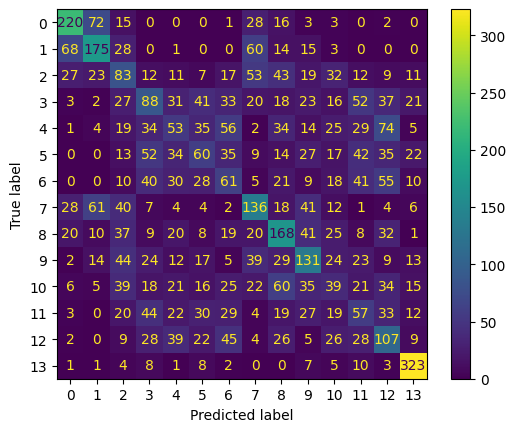

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(round_perms_results, round_perms_times)).plot()

(0.0, 1.0)

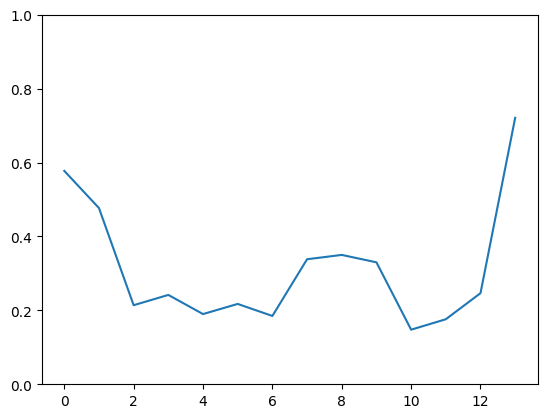

In [22]:
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
plt.plot(precision_score(round_perms_results, round_perms_times, average=None))
plt.ylim([0, 1])

### Copy permutations

In [19]:
sig_strength_copy_perms = np.zeros(copy_perms_labels.shape[0], dtype=SignalStrength)
n_feat_copy_perms = np.zeros(copy_perms_labels.shape[0], dtype=int)

for copy_index in range(copy_perms_labels.shape[0]):
    signal_strengths = [
        SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_5_350000_5134_copy_perms_{copy_index}_sost.pic"),
        #SIGNAL_STRENGTHS_METHODS["PCA"](f"./leakage_points/f_5_350000_5134_copy_perms_{copy_index}_pca.pic"),
        #SIGNAL_STRENGTHS_METHODS["DOM"](f"./leakage_points/f_5_350000_5134_copy_perms_{copy_index}_dom.pic"),
        #SIGNAL_STRENGTHS_METHODS["SNR"](f"./leakage_points/f_5_350000_5134_copy_perms_{copy_index}_snr.pic"),
        #SIGNAL_STRENGTHS_METHODS["CORR"](f"./leakage_points/f_5_350000_5134_copy_perms_{copy_index}_corr.pic"),
    ]

    copy_perms_times, copy_perms_results = b4_gridsearch_cv(signal_strengths, n_folds, train_sizes, val_sizes, num_features, traces_total, copy_perms_labels[copy_index])

    #sig_strength_copy_perms[copy_index] = SIGNAL_STRENGTHS_METHODS[signal_strengths[np.unravel_index(np.argmax(np.mean(copy_perms_results, axis=-1)), copy_perms_results.shape[:-1])[0]].name](f"./leakage_points/f_355134_copy_perms_{copy_index}_best.pic")
    #n_feat_copy_perms[copy_index] = num_features[np.unravel_index(np.argmax(np.mean(copy_perms_results, axis=-1)), copy_perms_results.shape[:-1])[3]]


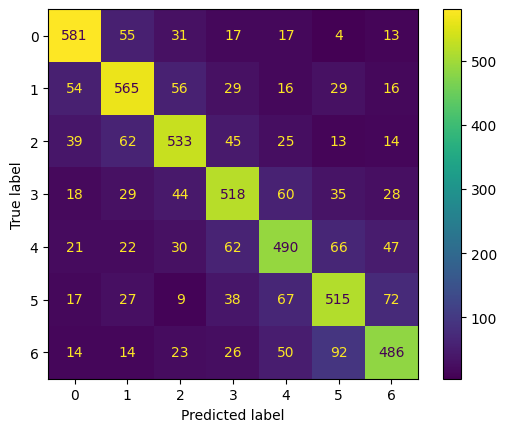

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(copy_perms_results, copy_perms_times)).plot()

(0.0, 1.0)

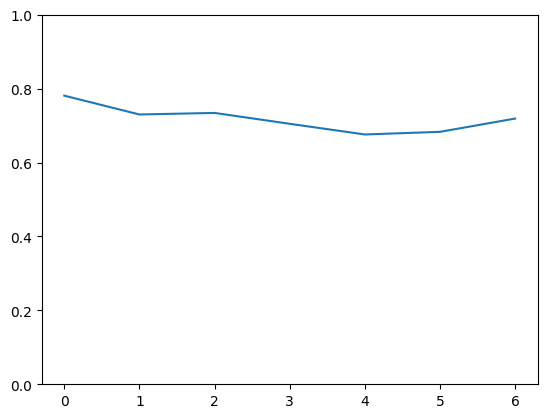

In [23]:
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
plt.plot(precision_score(copy_perms_results, copy_perms_times, average=None))
plt.ylim([0, 1])

### Mask values

In [8]:
import pickle as pic
import plotly.express as px
with open("./leakage_points/f_5_350000_5134_rws_perms_sost.pic", "rb") as r:
    sig_rws = pic.load(r)
sig_masks_rws = []
for keyround_idx in range(KEYROUND_WIDTH_B4):
    for share_idx in range(NR_SHARES):
        try:
            with open(f"./leakage_points/f_395133_masks_rws_{keyround_idx}_{share_idx}_sost.pic", "rb") as r:
                sig_masks_rws.append(pic.load(r))
        except OSError:
            pass

with open("./leakage_points/f_355134_round_perms_best.pic", "rb") as r:
    sig_round_best = pic.load(r)
sig_copy_best = []
sig_masks_best = []
for round_idx in range(EARLIEST_ROUND, LATEST_ROUND):
    with open(f"./leakage_points/f_355134_copy_perms_{round_idx}_best.pic", "rb") as r:
        sig_copy_best.append(pic.load(r))
    for block_idx in range(BLOCK_WIDTH_B4):
        with open(f"./leakage_points/f_355134_masks_{round_idx}_{block_idx}_best.pic", "rb") as r:
            sig_masks_best.append(pic.load(r))


In [ ]:
px.line(y=[sig_rws] + sig_masks_rws + [sig_round_best] + sig_copy_best + sig_masks_best)

In [24]:
num_features = [20]

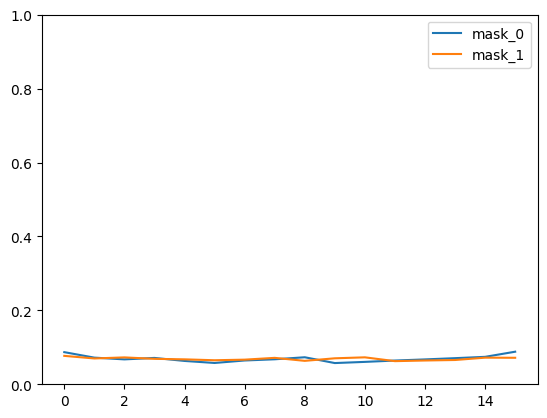

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

sig_strength_masks = np.zeros((masks_labels.shape[0], masks_labels.shape[1]), dtype=SignalStrength)
n_feat_masks = np.zeros((masks_labels.shape[0], masks_labels.shape[1]), dtype=int)

precisions_0 = []
precisions_1 = []
for round_idx in range(masks_labels.shape[0]):
    for block_idx in range(masks_labels.shape[1]):
        signal_strengths = [
            SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_5_350000_5134_masks_{round_idx}_{block_idx}_1_sost.pic"),
            #SIGNAL_STRENGTHS_METHODS["PCA"](f"./leakage_points/f_5_350000_5134_masks_{round_idx}_{block_idx}_{share_idx}_pca.pic"),
            #SIGNAL_STRENGTHS_METHODS["DOM"](f"./leakage_points/f_5_350000_5134_masks_{round_idx}_{block_idx}_{share_idx}_dom.pic"),
            #SIGNAL_STRENGTHS_METHODS["SNR"](f"./leakage_points/f_5_350000_5134_masks_{round_idx}_{block_idx}_{share_idx}_snr.pic"),
            #SIGNAL_STRENGTHS_METHODS["CORR"](f"./leakage_points/f_5_350000_5134_masks_{round_idx}_{block_idx}_{share_idx}_corr.pic"),
        ]
        masks_times, masks_results = b4_gridsearch_cv(signal_strengths, n_folds, train_sizes, val_sizes, num_features, traces_total, masks_labels[round_idx, block_idx].T, masking=True)

        #sig_strength_masks[round_idx, block_idx] = SIGNAL_STRENGTHS_METHODS[signal_strengths[np.unravel_index(np.argmax(np.mean(masks_results, axis=-1)), masks_results.shape[:-1])[0]].name](f"./leakage_points/f_355134_masks_{round_idx}_{block_idx}_best.pic")
        #n_feat_masks[round_idx, block_idx] = num_features[np.unravel_index(np.argmax(np.mean(masks_results, axis=-1)), masks_results.shape[:-1])[3]]
        #ConfusionMatrixDisplay(confusion_matrix(masks_results // 16, masks_times // 16)).plot()
        #plt.show()
        #plt.plot(precision_score(masks_results // 16, masks_times // 16, average=None))
        precisions_0.append(precision_score(masks_results // 16, masks_times // 16, average=None))
        #plt.ylim([0, 1])
        #plt.show()
        
        #ConfusionMatrixDisplay(confusion_matrix(masks_results % 16, masks_times % 16)).plot()
        #plt.show()
        #plt.plot(precision_score(masks_results % 16, masks_times % 16, average=None))
        precisions_1.append(precision_score(masks_results % 16, masks_times % 16, average=None))
        #plt.ylim([0, 1])
        #plt.show()
plt.plot(np.mean(precisions_0, axis=0), label='mask_0')
plt.plot(np.mean(precisions_1, axis=0), label='mask_1')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Mask values during RWS

In [6]:
for keyround_idx in range(masks_labels_rws.shape[0]):
    print(f"{keyround_idx}", end="\r")
    sig_strength = SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_395133_masks_rws_{keyround_idx}_0_sost.pic")
    sig_strength.fit(traces_total, masks_labels_rws[keyround_idx, 0], num_features[0])

    sig_strength = SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_395133_masks_rws_{keyround_idx}_1_sost.pic")
    sig_strength.fit(traces_total, masks_labels_rws[keyround_idx, 1], num_features[0])

## Extraction phase

In [43]:
seeds_trainval, seeds_test, traces_trainval, traces_test, round_perms_trainval,round_perms_test, copy_perms_trainval, copy_perms_test, masks_trainval, masks_test = b4_train_test_split(seeds_total, traces_total, round_perms_labels, copy_perms_labels.T, np.transpose(masks_labels, (3, 0, 1, 2)), train_size=train_sizes[0], val_sizes=val_sizes)
copy_perms_trainval, copy_perms_test = copy_perms_trainval.T, copy_perms_test.T
masks_trainval, masks_test = np.transpose(masks_trainval, (1, 2, 3, 0)), np.transpose(masks_test, (1, 2, 3, 0))

sig_strength_round_perms = SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_{train_sizes[0] + val_sizes[0]}_round_perms_best.pic")
sig_strength_round_perms_pca = SIGNAL_STRENGTHS_METHODS["PCA"](f"./leakage_points/f_{train_sizes[0] + val_sizes[0]}_round_perms_best_after_pca_5.pic")
best_round_perms_model = b4_train(sig_strength_round_perms_pca, 5, sig_strength_round_perms.fit(traces_trainval, round_perms_trainval, 200).transform(traces_trainval), round_perms_trainval)

sig_strength_copy_perms = np.zeros(copy_perms_labels.shape[0], dtype=SignalStrength)
sig_strength_copy_perms_pca = np.zeros(copy_perms_labels.shape[0], dtype=SignalStrength)
best_copy_perms_model = np.zeros(copy_perms_labels.shape[0], dtype=B4GaussianEstimator)
for copy_index in range(copy_perms_labels.shape[0]):
    sig_strength_copy_perms[copy_index] = SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_{train_sizes[0] + val_sizes[0]}_copy_perms_{copy_index}_best.pic")
    sig_strength_copy_perms_pca[copy_index] = SIGNAL_STRENGTHS_METHODS["PCA"](f"./leakage_points/f_{train_sizes[0] + val_sizes[0]}_copy_perms_{copy_index}_best_after_pca_5.pic")
    best_copy_perms_model[copy_index] = b4_train(sig_strength_copy_perms_pca[copy_index], 5, sig_strength_copy_perms[copy_index].fit(traces_trainval, copy_perms_trainval[copy_index], 200).transform(traces_trainval), copy_perms_trainval[copy_index])

sig_strength_masks = np.zeros((masks_labels.shape[0], masks_labels.shape[1]), dtype=SignalStrength)
sig_strength_masks_pca = np.zeros((masks_labels.shape[0], masks_labels.shape[1]), dtype=SignalStrength)
best_masks_models = np.zeros((masks_labels.shape[0], masks_labels.shape[1]), dtype=B4GaussianEstimator)
for round_idx in range(masks_labels.shape[0]):
    for block_idx in range(masks_labels.shape[1]):
        sig_strength_masks[round_idx, block_idx] = SIGNAL_STRENGTHS_METHODS["SOST"](f"./leakage_points/f_{train_sizes[0] + val_sizes[0]}_masks_{round_idx}_{block_idx}_best.pic")
        sig_strength_masks_pca[round_idx, block_idx] = SIGNAL_STRENGTHS_METHODS["PCA"](f"./leakage_points/f_{train_sizes[0] + val_sizes[0]}_masks_{round_idx}_{block_idx}_best_after_pca_5.pic")
        best_masks_models[round_idx, block_idx] = b4_train(sig_strength_masks_pca[round_idx, block_idx], 5, sig_strength_masks[round_idx, block_idx].fit(traces_trainval, masks_trainval[round_idx, block_idx, 1], 20).transform(traces_trainval), masks_trainval[round_idx, block_idx].T, masking=True)


In [44]:
predicted_round_perm_probas = best_round_perms_model.predict_proba(sig_strength_round_perms_pca.transform(sig_strength_round_perms.transform(traces_test)))

predicted_copy_perm_probas = np.zeros((seeds_test.shape[0], LATEST_ROUND - EARLIEST_ROUND, BLOCK_WIDTH_B4))
for copy_index in range(copy_perms_labels.shape[0]):
    predicted_copy_perm_probas[:, copy_index, :] = best_copy_perms_model[copy_index].predict_proba(sig_strength_copy_perms_pca[copy_index].transform(sig_strength_copy_perms[copy_index].transform(traces_test)))

predicted_masks_probas = np.zeros((seeds_test.shape[0], LATEST_ROUND - EARLIEST_ROUND, BLOCK_WIDTH_B4, len(KEY_ALPHABET) ** NR_SHARES))
for round_idx in range(masks_labels.shape[0]):
    for block_idx in range(masks_labels.shape[1]):
        predicted_masks_probas[:, round_idx, block_idx, :] = best_masks_models[round_idx, block_idx].predict_proba(sig_strength_masks_pca[round_idx, block_idx].transform(sig_strength_masks[round_idx, block_idx].transform(traces_test)))

In [ ]:
with open(f"predicted_probas_sost_plus_pca_5_features_{train_sizes[0] + val_sizes[0]}_{predicted_round_perm_probas.shape[0]}.pic", "wb") as w:
    pic.dump((key, seeds_test, predicted_round_perm_probas, predicted_copy_perm_probas, predicted_masks_probas), w)
recovered_key = reconstruct_key(seeds_test, predicted_round_perm_probas, predicted_copy_perm_probas, predicted_masks_probas)

In [6]:
with open("classifications_per_key_nibble.pic", "rb") as r:
    classification_per_key_nibble = pic.load(r)
with open("recovered_key.pic", "rb") as r:
    recovered_key = pic.load(r)
with open(f"predicted_probas_sost_plus_pca_5_features_{"255134"}_{"139999"}.pic", "rb") as r:
    key, _, _, _, _ = pic.load(r)


In [7]:
key[7]

2

In [5]:
classification_per_key_nibble[7]

array([-3436215.48021777, -3436214.92274996, -3436215.15075742,
       -3436215.46565341, -3436218.24116547, -3436223.46590457,
       -3436216.28650038, -3436221.19094874, -3436221.32264399,
       -3436212.70483956, -3436218.96873337, -3436216.13280323,
       -3436215.46152226, -3436219.7136579 , -3436220.49277725,
       -3436209.0321075 ])

In [4]:
classification_per_key_nibble[7]

array([-11230964.89474829, -11230954.7047798 , -11230977.10273724,
       -11230964.26491154, -11230966.84736726, -11230961.44455051,
       -11230953.56929098, -11230956.39112463, -11230966.41676653,
       -11230950.65282884, -11230937.19763803, -11230960.92638953,
       -11230944.79565219, -11230963.86733168, -11230964.73461355,
       -11230964.95493827])

In [25]:
classification_per_key_nibble[7]

array([-2.40467703e+09, -2.40467654e+09, -2.40467674e+09, -2.40467568e+09,
       -2.40467705e+09, -2.40467691e+09, -2.40467566e+09, -2.40467681e+09,
       -2.40467629e+09, -2.40467788e+09, -2.40467802e+09, -2.40467595e+09,
       -2.40467687e+09, -2.40467740e+09, -2.40467764e+09, -2.40467530e+09])